# Physical Models: Percolation
Our week 7 workbook, available on Github from the powderflask/cap-comp215 repository.
As usual, the first code block just imports the modules we will use.

In [247]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')
# Remove this to run the notebook with actual random data
np.random.seed(18)

### Helpers
We're starting to collect some useful re-usable bits of code - we should consider putting these in an importable module...

In [248]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [249]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Simple Percolation Model
  Percolation refers to the movement and filtering of fluids through porous materials. Broad applications have been developed in physics, chemistry, and materials science, based on connectivity in systems modeled as lattices or graphs. [wikipedia](https://en.wikipedia.org/wiki/Percolation)

In the percolation model below, a 2D block of material is made up of cells where each cell is either porous or non-porous.
We start with a row of wet cells at the top. During each time step, a cell becomes wet if it is porous and at least one neighbor is wet (using a 4-cell neighborhood). If water reaches the bottom row then the percolation cluster is permeable otherwise impermeable.

Porous cells have state 1 and wet cells have state 5, so if a cell has a wet neighbor, the sum of the neighbors will by 5 or more.

In [250]:
class Percolation:
    """ Percolation CA, representing a grid of porous and non-porous cells. """
    NONPOROUS = 0
    POROUS = 1
    WET = 5

    # Diffuse only to cardinal neighbours
    kernel = np.array([[0,  1, 0],
                       [1,  0, 1 ],
                       [0,  1, 0]])

    def __init__(self, n, q=0.5):
        """ Initializes nxn model with porous cells occurring with probability q
            n: number of rows / cols in the grid
            q: probability of a cell being porous
        """
        self.q = q
        self.array = np.random.choice([self.POROUS, self.NONPOROUS], (n, n), p=[q, 1-q])

        # fill the top row with wet cells
        self.array[0] = self.WET

    def step(self):
        """ Simulate one time step. """
        c = correlate2d(self.array, self.kernel, mode='same')
        wet = (self.array==self.POROUS) & (c>=self.WET)  # porous cells that have at least one wet neighbour
        self.array[wet] = self.WET

    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == self.WET)

    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == self.WET)

    def simulate(self):
        """
        Run percolation simulation until either water reaches bottom row or percolation stops
        Return a tuple, (percs, n_steps) True iff the models block percolates from top to bottom after n_steps
        """
        n_wet = [0, self.num_wet(),]  # a list of # cells wet in each timestep.
        def still_percolating():
            """ Return true if model is still percolating, i.e. # wet at time t-1 > # wet at t-2 """
            return n_wet[-1] > n_wet[-2]

        while not self.bottom_row_wet() and still_percolating():
            self.step()
            n_wet.append(self.num_wet())

        return bool(self.bottom_row_wet()), len(n_wet)-1

    def is_permeable(self):
        """
        Return True iff the models block percolates from top to bottom
        """
        return self.simulate()[0]

    def reset(self):
        """ Reset all WET cells back to permeable and wet the top row again. """
        self.array[self.array==self.WET] = self.POROUS
        self.array[0] = self.WET

    def draw(self, axes=None, step=''):
        """Draws the cells on given axes."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        plot_2D_array(self.array, axes, cmap='Reds', title=f'Percolation {step}')

Here's example showing a percolation simulation in 3 states...

Model percolates after 10 steps.


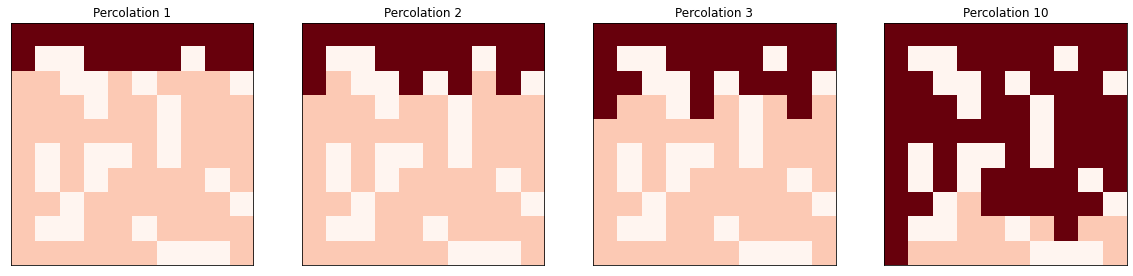

In [251]:
perc = Percolation(n=10, q=0.7)

fig, ax = plt.subplots(figsize=(20, 5))
for step in range(1, 4):
    plt.subplot(1, 4, step)
    perc.step()
    perc.draw(step=step)

perc.reset()
percs, n_step = perc.simulate()
plt.subplot(1, 4, 4)
perc.draw(step=n_step)

print(f'Model {"percolates" if percs else "does not percolate"} after {n_step} steps.')

## Experiments: Probability of Percolating
For any given value of $q$ we might ask: what is the likelihood that such a percolation cluster is permeable?

In [252]:
def proportion_percolating(n=100, q=0.5, iters=100):
    """Estimates the probability of percolating at a given value of q.

    n: int number of rows and columns
    q: probability that a cell is permeable
    iters: number of random percolation clusters to test

    returns: float proportion of percolating clusters that were permeable.
    """
    results = [Percolation(n, q).is_permeable() for i in range(iters)]
    return np.mean(results)

In [253]:
q = 0.55
f'At q={q}, the probability of percolating is {proportion_percolating(q=q)}.'

'At q=0.55, the probability of percolating is 0.0.'

In [254]:
q = 0.65
f'At q={q}, the probability of percolating is {proportion_percolating(q=q)}.'

'At q=0.65, the probability of percolating is 1.0.'

### Critical Value of $q$
Somewhere in this range there is a **"critical value"** of $q$ where the likelihood of percolating rapidly changes from near 0 to near 1!

If we can fit a mathematical model to the simulation data, we could derive the point of maximum slope on this curve...

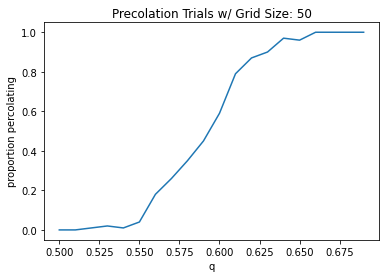

CPU times: user 13.9 s, sys: 249 ms, total: 14.2 s
Wall time: 14.1 s


In [255]:
def plot_prop_percolating(n=50, qs=np.arange(0.50, .70, 0.01), iters=100):
    """ Plot the proportion of percolating n x n clusters for a range of values of q """

    ps = []  # proportion of trials that percolated for blocks with parameter q
    for q in qs:
        ps.append( proportion_percolating(n, q=q, iters=iters) )

    plt.plot(qs, ps)
    title=f'Precolation Trials w/ Grid Size: {n}'
    plt.gca().set(title=title, xlabel='q', ylabel = 'proportion percolating')
    plt.show()

%time plot_prop_percolating()

or we could try honing in on the critical value with the children's game of warmer / colder...

In [256]:
def find_critical(grid_size=100, q=(0.61+0.56)/2, n_trials=100):
    """Estimate critical value of q via random walk algorithm.

    returns: list of q that "wander around" q's critical value
    """
    qs = [q]
    for i in range(n_trials):
        perc = Percolation(grid_size, q)
        if perc.is_permeable():
            q -= 0.005
        else:
            q += 0.005
        qs.append(q)
    return qs

In [257]:
grid_size = 100
qs = find_critical(grid_size)
f'Mean Critical value of q ~{np.mean(qs):0.4f} for grid size: {grid_size}'

'Mean Critical value of q ~0.5932 for grid size: 100'

Let's visualize the variation we get across trials of the random walk algorithm, and determine if grid size has any influence...

In [258]:
def plot_trials(grid_size, n_trials):
    """ Plot given number of trials on given grid size to find critical value of q """
    qs = find_critical(grid_size, n_trials=n_trials)

    plt.scatter(range(len(qs)), qs)
    title = f'q_crit={np.mean(qs):0.3f} after {n_trials} Precolation Trials w/ Grid Size: {grid_size}'
    plt.gca().set(title=title, xlabel = 'Trial #', ylabel = 'Estimated q_crit')
    plt.show()

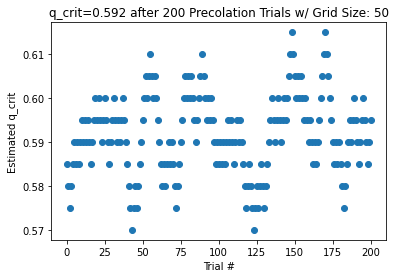

CPU times: user 2.91 s, sys: 133 ms, total: 3.05 s
Wall time: 2.92 s


In [259]:
%time plot_trials(grid_size=50, n_trials=200)

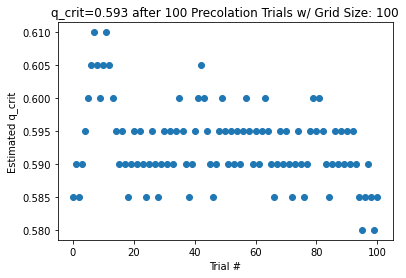

CPU times: user 6.9 s, sys: 195 ms, total: 7.1 s
Wall time: 6.99 s


In [260]:
%time plot_trials(grid_size=100, n_trials=100)

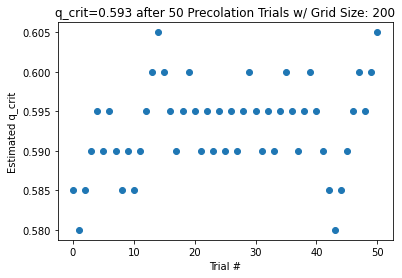

CPU times: user 22.1 s, sys: 285 ms, total: 22.4 s
Wall time: 22.4 s


In [261]:
%time plot_trials(grid_size=200, n_trials=50)

### Epilogue: what just happend?
We confirmed there appears to be scale-invariant property of percolation blocks:
If porous and non-porous cells in the block are distributed at random, with probability $q$, then at a critical value of $q ~= 0.59$ there is a **"phase change"** from impermeable to permeable.

#### Questions to ponder
 * how is this system similar to the E-R graphs we studied in Lab 4?
 * how would you model the percolation system with a graph?
 * would you expect similar experimental results using a graph instead of a CA?
 * which method of simulating this system likely yields a more time-efficient (faster) solution?